# Agentic RAG with Voyage AI, MongoDB, and Claude 3.5 Sonnet

In this notebook, we'll build a coding assistant that leverages agentic RAG using [Voyage AI](https://voyageai.com) for vectors, [MongoDB](https://www.mongodb.com/) for vector search, and [Anthropic](https://www.anthropic.com/) for the LLM.

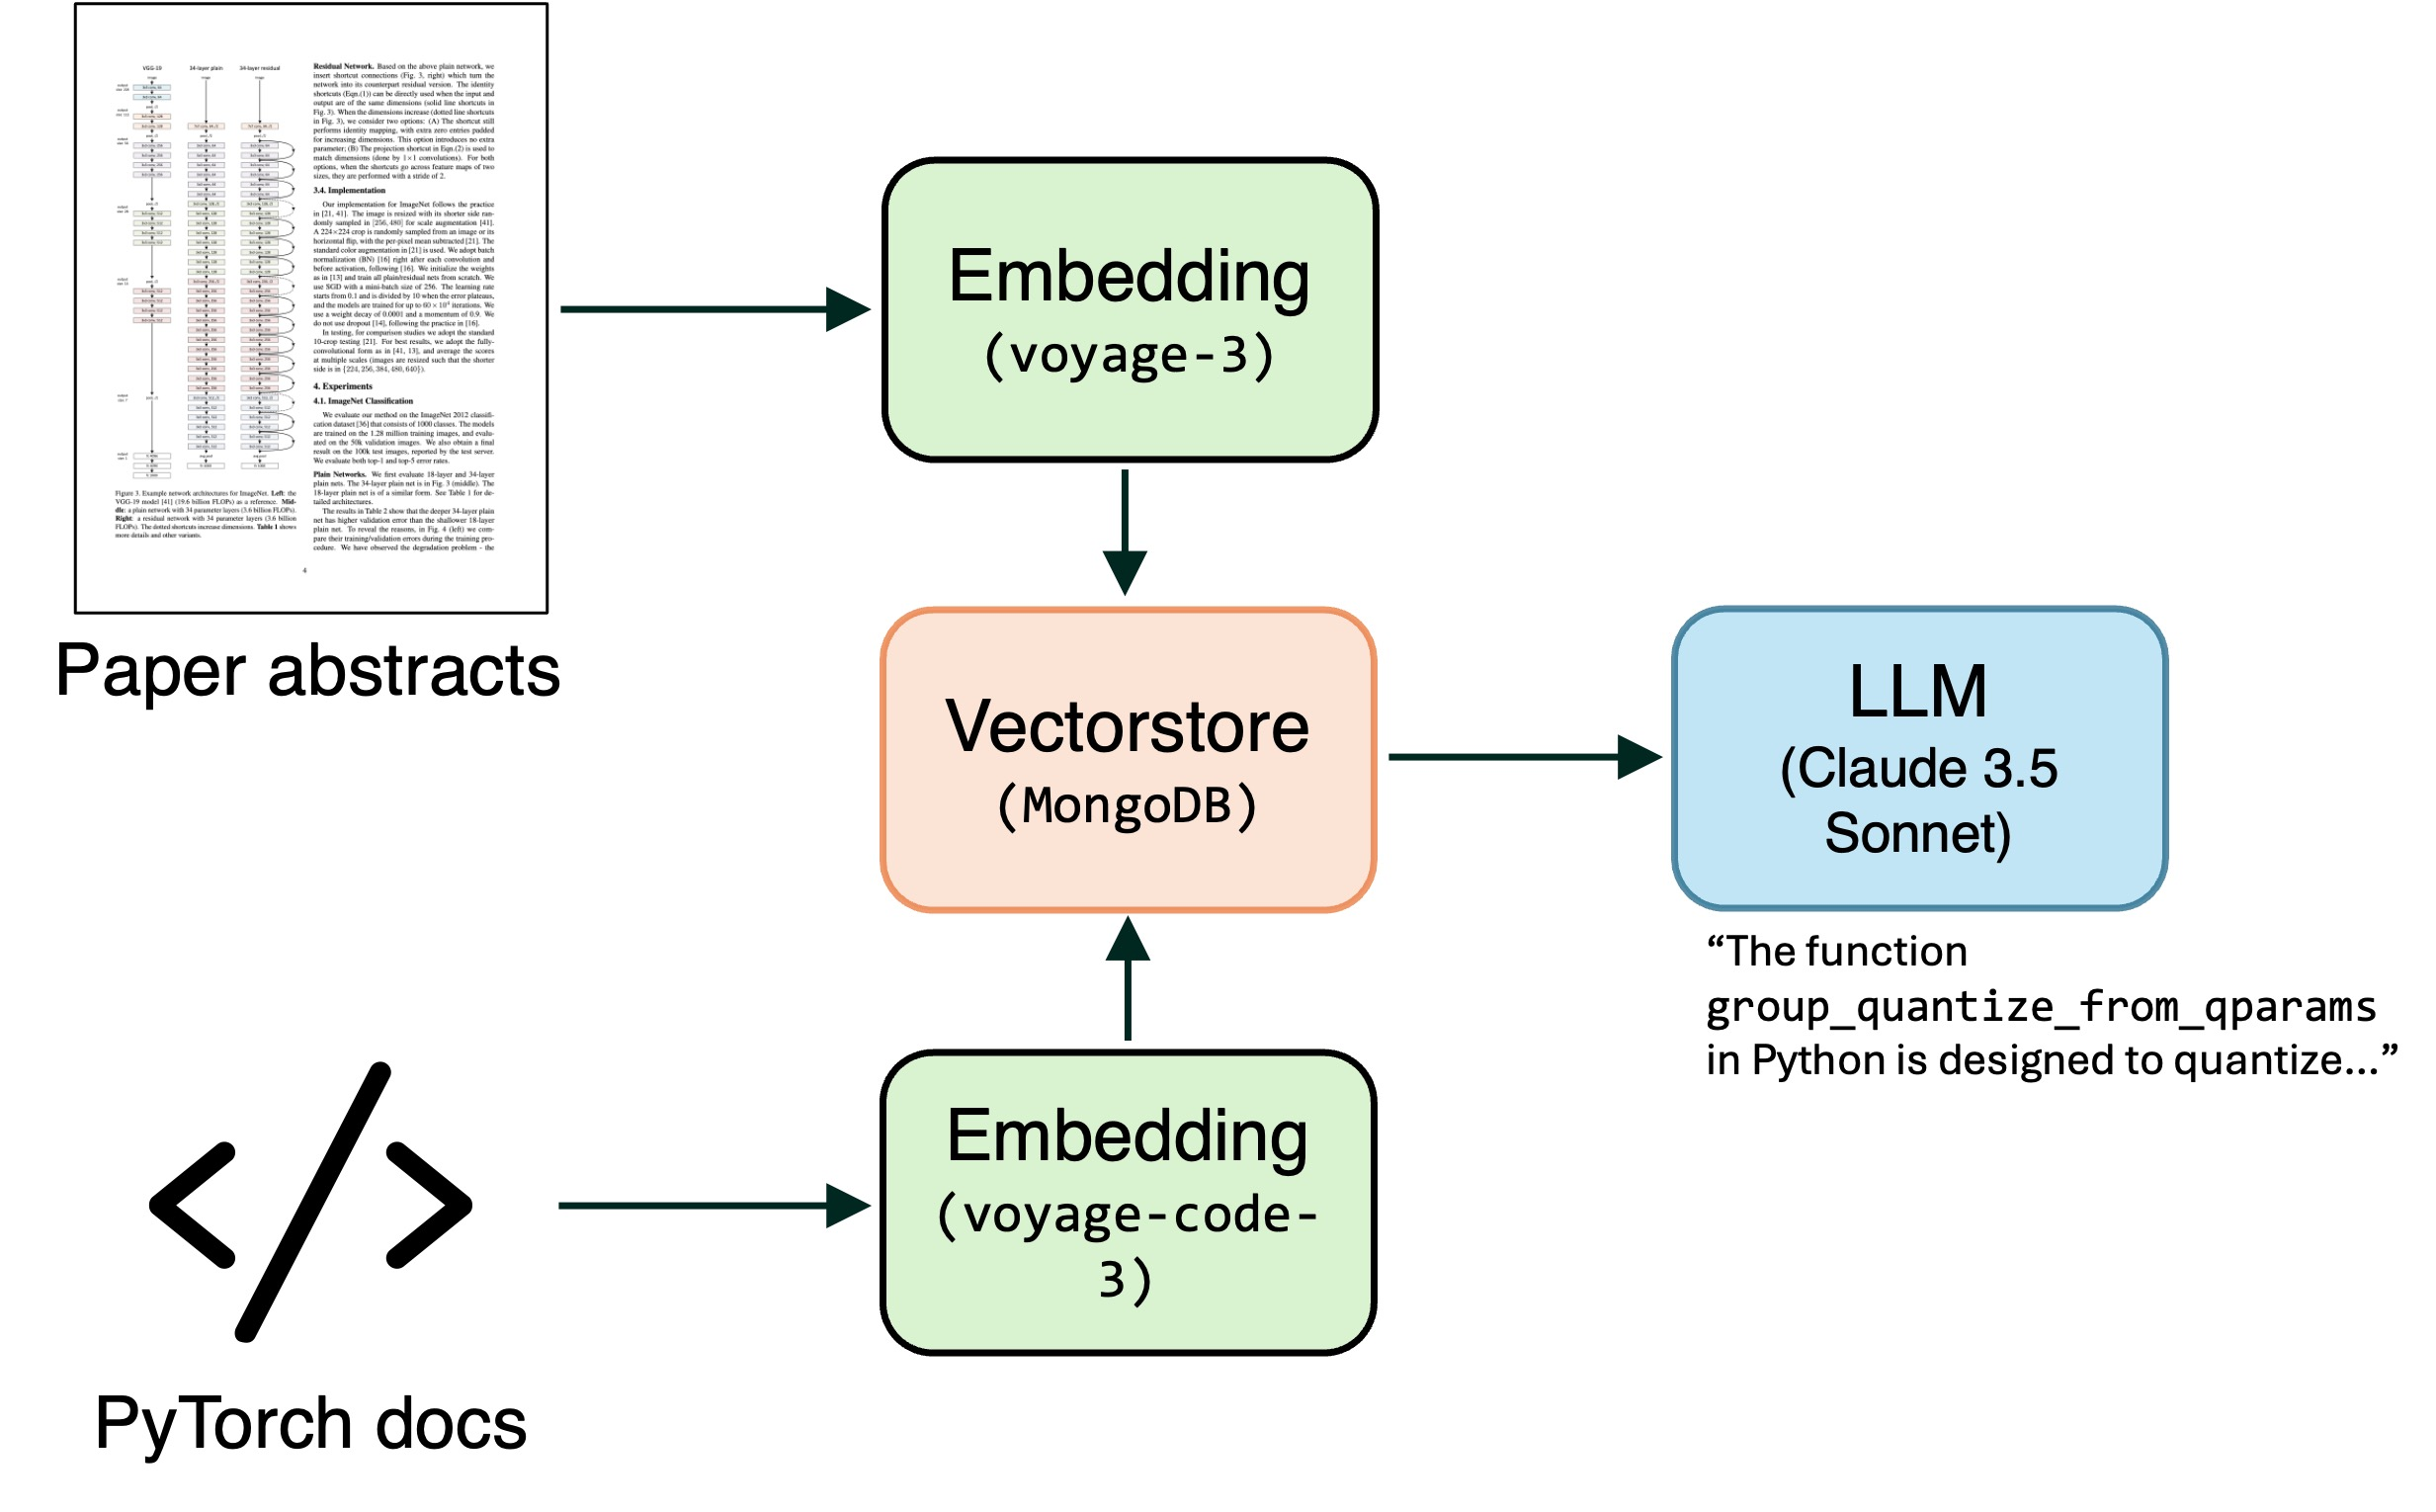

Let's dive in!

## 0. Some prep work

Let's walk through a bit of setup first before running this notebook. You'll need three things:
1. A __Voyage API key__ to vectorize documents and queries retrieval. You can get one [here](https://dash.voyageai.com/). After that, create a Google Colab secret called `VOYAGE_API_KEY` and set it to that.
2. A __MongoDB Atlas instance__ to store the vectors we generate. You can create one [here](https://cloud.mongodb.com/). After that, set the `MONGO_USERNAME`, `MONGO_PASSWORD`, and `MONGO_HOST` secrets.
3. An __Anthropic API key__ to build out the agent using tool-calling. You can get one [here](https://console.anthropic.com/). After that, set the `ANTHROPIC_API_KEY` secret.

## 1. Install packages

Now it's time to get started -- let's begin by installing some packages. For this notebook, all you'll need:

- `voyageai` for calling accessing the multimodal model via the Voyage API
- `pymongo` for loading some test data we'll be using later on in the notebook
- `anthropic` for taking screenshots of documents, slides, and other visual data embedded inside PDFs
- `pandas` for downloading and processing a dataset of ArXiv paper metadata

There are also some useful functions for building retrieval systems in the `retrieval-toolbox` library. Specifically, we'll be using its query expansion and ETL tools.


In [ ]:
!pip install voyageai pymongo anthropic pandas
!pip install git+https://github.com/fzliu/retrieval-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 11.5 MB/s eta 0:00:00
  Cloning https://github.com/fzliu/retrieval-toolbox to /tmp/pip-req-build-4_k60m9w
  Running command git clone --filter=blob:none --quiet https://github.com/fzliu/retrieval-toolbox /tmp/pip-req-build-4_k60m9w
  Resolved https://github.com/fzliu/retrieval-toolbox to commit 40c38b618ec11880afc7bc8fc7d8b63348db54a6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 48.9 MB/s eta 0:00:00
  Created wheel for retrieval-tools: filename=retrieval_tools-2024.11.19-py3-none-any.whl size=4858 sha256=cd150db8882f7fd615f9a259b00f103628440d98a3f0d93dec057c8ebb5c0b63
  Stored in directory: /tmp/pip-ephem-wheel-cache-6w0vni3j/wh

We'll also define some useful "constants" for this notebook. Please check out step 0 if there are any errors here:

In [ ]:
import os

from google.colab import userdata

In [ ]:
os.environ["VOYAGE_API_KEY"] = userdata.get("VOYAGE_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = userdata.get("ANTHROPIC_API_KEY")

# MongoDB parameters
MONGO_USERNAME = userdata.get("MONGO_USERNAME")
MONGO_PASSWORD = userdata.get("MONGO_PASSWORD")
MONGO_HOST = userdata.get("MONGO_HOST")

# If `True`, drop MongoDB collections if they exist
DROP_OLD_COLLECTION = True

# For the PyTorch documentation
PYTORCH_DOCS_URL = "https://media.githubusercontent.com/media/fzliu/retrieval-toolbox/refs/heads/main/notebooks/assets/pytorch_v2.5.0_documentation.md"

# Batch size for embedding with Voyage
EMBED_BATCH_SIZE = 32

## 2. Create a Voyage client

In [ ]:
import voyageai

In [ ]:
voyage = voyageai.Client()

## 3. Setting up MongoDB

In [ ]:
from pymongo.mongo_client import MongoClient
from pymongo.operations import SearchIndexModel

Let's first create a connection to our MongoDB instance:

In [ ]:
uri = f"mongodb+srv://{MONGO_USERNAME}:{MONGO_PASSWORD}@{MONGO_HOST}"
mongo = MongoClient(uri)

We'll need to create two collections, one to store information associated with the papers we may want the assistant to implement, and another to store the latest PyTorch documentation:

In [ ]:
db = mongo["coding_assistant"]
coll_papers = db["papers"]
coll_torchdocs = db["torchdocs"]
if DROP_OLD_COLLECTION:
    coll_papers.drop()
    coll_torchdocs.drop()

## 4. Get ArXiv papers and PyTorch docs

In [ ]:
import urllib.request
from dataclasses import asdict, dataclass

import pandas as pd
from retrieval.chunkers import chunk_markdown

Now we can pull metadata for the ArXiv papers. Let's define a container to hold all of the data for each result:

In [ ]:
@dataclass
class ArXivPaper:
    """Data for a single result from the ArXiv API."""

    title: str
    summary: str
    authors: list[str]
    pdf_link: str
    updated: str
    categories: list[str]
    vector: list[float] = None


@dataclass
class BasicText:
    """Data for a single text string plus its vector."""

    text: str
    vector: list[float] = None

Now we can grab metadata (title, summary, URL, etc...) popular ArXiv papers from the past decade here:

In [ ]:
df = pd.read_json("hf://datasets/jamescalam/ai-arxiv2/train.jsonl", lines=True)

arxiv_papers = []
for index, row in df.iterrows():
    arxiv_papers.append(
        ArXivPaper(
            title=row["title"],
            summary=row["summary"],
            authors=row["authors"].split(", "),
            pdf_link=row["source"],
            updated=row["updated"],
            categories=row["categories"].split(", "),
        )
    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print("First three papers")
print("------------------")
print()
for n in range(3):
    print(arxiv_papers[n])
    print()

First three papers
------------------

ArXivPaper(title='Mixtral of Experts', summary='We introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model.\nMixtral has the same architecture as Mistral 7B, with the difference that each\nlayer is composed of 8 feedforward blocks (i.e. experts). For every token, at\neach layer, a router network selects two experts to process the current state\nand combine their outputs. Even though each token only sees two experts, the\nselected experts can be different at each timestep. As a result, each token has\naccess to 47B parameters, but only uses 13B active parameters during inference.\nMixtral was trained with a context size of 32k tokens and it outperforms or\nmatches Llama 2 70B and GPT-3.5 across all evaluated benchmarks. In particular,\nMixtral vastly outperforms Llama 2 70B on mathematics, code generation, and\nmultilingual benchmarks. We also provide a model fine-tuned to follow\ninstructions, Mixtral 8x7B - Instruct, that surpas

Now we can move to the PyTorch docs. You can grab them on Github:

In [ ]:
with urllib.request.urlopen(PYTORCH_DOCS_URL) as r:
    pytorch_docs = r.read().decode("utf-8")

To chunk them, we can use the `chunk_markdown` function in the `retrieval_tools` library:

In [ ]:
pytorch_docchunks = []
for text in chunk_markdown(pytorch_docs):
    pytorch_docchunks.append(BasicText(text=text))

In [ ]:
print("First three chunks")
print("------------------")
print()
for n in range(3):
    print(pytorch_docchunks[n])
    print()

First three chunks
------------------

BasicText(text='# PyTorch main documentation\n2,731–3,473 minutes\n* * *\nPyTorch is an optimized tensor library for deep learning using GPUs and CPUs.\nFeatures described in this documentation are classified by release status:\n> _Stable:_ These features will be maintained long-term and there should generally be no major performance limitations or gaps in documentation. We also expect to maintain backwards compatibility (although breaking changes can happen and notice will be given one release ahead of time).\n>\n> _Beta:_ These features are tagged as Beta because the API may change based on user feedback, because the performance needs to improve, or because coverage across operators is not yet complete. For Beta features, we are committing to seeing the feature through to the Stable classification. We are not, however, committing to backwards compatibility.\n>\n> _Prototype:_ These features are typically not available as part of binary distribut

## 5. Vectorize and insert

Now, we can vectorize all summaries with Voyage AI and insert the full documents into MongoDB. To avoid hitting rate limits, we'll batch the results:

In [ ]:
for n in range(0, len(arxiv_papers), EMBED_BATCH_SIZE):
    batch = arxiv_papers[n : n + EMBED_BATCH_SIZE]
    result = voyage.embed(
        [paper.summary for paper in batch],
        model="voyage-3",
        input_type="document",
        truncation=True,
    )
    for m in range(len(batch)):
        batch[m].vector = result.embeddings[m]
        coll_papers.insert_one(asdict(batch[m]))

We can do the same for the PyTorch documentation as well:

In [ ]:
for n in range(0, len(pytorch_docchunks), EMBED_BATCH_SIZE):
    batch = pytorch_docchunks[n : n + EMBED_BATCH_SIZE]
    result = voyage.embed(
        [chunk.text for chunk in batch],
        model="voyage-code-3",
        input_type="document",
        truncation=True,
    )
    for m in range(len(batch)):
        batch[m].vector = result.embeddings[m]
        coll_torchdocs.insert_one(asdict(batch[m]))

We'll also need to create indexes over these two collections. We only need to specify two options per index:
- `dimensions`: the length of the output vectors
- `metric`: the metric we'll use to compute similarity scores

We're using cosine similarity (dot product of normalized vectors) with `voyage-3` (length 1024) to vectorize the paper summaries and `voyage-code-3` (length 1024) to vectorize the PyTorch documentation:

In [ ]:
coll_papers.create_search_index(
    model=SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "numDimensions": 1024,  # voyage-3
                    "path": "vector",
                    "similarity": "dotProduct",
                }
            ]
        },
        name="vector_index",
        type="vectorSearch",
    )
)

'vector_index'

In [ ]:
coll_torchdocs.create_search_index(
    model=SearchIndexModel(
        definition={
            "fields": [
                {
                    "type": "vector",
                    "numDimensions": 1024,  # voyage-code-3
                    "path": "vector",
                    "similarity": "dotProduct",
                }
            ]
        },
        name="vector_index",
        type="vectorSearch",
    )
)

'vector_index'

## 6. Defining tools for Claude

In [ ]:
import base64

import anthropic
from retrieval.etl import pdf_url_to_screenshots

In [ ]:
claude = anthropic.Anthropic()

Let's first define a tool which Claude can use to search for relevant papers.

In [ ]:
arxiv_search_tool = {
    "name": "paper_search",
    "description": "A tool that retrieves the most relevant recent ML paper from arXiv in image format. If you see an algorithm or acronym which you are unfamiliar with, use this tool. The returned paper may or may not be relevant -- it is up to you to determine if they are or are not.",
    "input_schema": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "The topic to search arXiv ML papers for.",
            },
        },
        "required": ["topic"],
    },
}


def arxiv_search(query: str):
    query_vector = voyage.embed(
        [query], model="voyage-3", input_type="query"
    ).embeddings[0]
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "queryVector": query_vector,
                "path": "vector",  # field to search
                "exact": True,
                "limit": 1,
            }
        },
        {
            "$project": {
                "_id": 0,
                "title": 1,
                "summary": 1,
                "author": 1,
                "pdf_link": 1,
                "updated": 1,
                "categories": 1,
                "score": {"$meta": "vectorSearchScore"},
            }
        },
    ]
    url = coll_papers.aggregate(pipeline).to_list()[0]["pdf_link"]
    return pdf_url_to_screenshots(url)

Next, we'll need a tool which Claude can use to reference the most recent PyTorch documentation.

In [ ]:
torchdoc_search_tool = {
    "name": "torchdoc_search",
    "description": "A tool that retrieves the latest PyTorch documentation. Use this tool to ensure that you are using the PyTorch functions correctly when you build neural networks. The returned results may or may not be relevant -- it is up to you to determine if they are or are not.",
    "input_schema": {
        "type": "object",
        "properties": {
            "query": {
                "type": "string",
                "description": "Functionality to search the PyTorch documentation for.",
            },
        },
        "required": ["topic"],
    },
}


def torchdoc_search(query: str):
    query_vector = voyage.embed(
        [query], model="voyage-code-3", input_type="query"
    ).embeddings[0]
    pipeline = [
        {
            "$vectorSearch": {
                "index": "vector_index",
                "queryVector": query_vector,
                "path": "vector",  # field to search
                "exact": True,
                "limit": 10,
            }
        },
        {"$project": {"_id": 0, "text": 1, "score": {"$meta": "vectorSearchScore"}}},
    ]
    result = coll_torchdocs.aggregate(pipeline)
    return "\n".join([r["text"] for r in result])

## 7. Putting it all together

Now we can put it all together. We'll give Claude access to the two retrieval tools (leveraging different sources of data and different embedding models). We can then chain them together to build a coding assistant grounded in knowledge from up-to-date research using the latest features from PyTorch:

In [ ]:
messages = [
    {"role": "user", "content": "Implement the Mamba state space model in PyTorch."}
]

while True:
    response = claude.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=4096,
        tools=[arxiv_search_tool, torchdoc_search_tool],
        messages=messages,
        extra_headers={"anthropic-beta": "pdfs-2024-09-25"},
    )

    if response.stop_reason == "tool_use":
        tool_use = next(block for block in response.content if block.type == "tool_use")
        tool_name = tool_use.name
        tool_input = tool_use.input

        if tool_name == "paper_search":
            tool_result = arxiv_search(*tool_input)
            content = [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": base64.b64encode(
                            r.convert("RGB").tobytes("jpeg", "RGB")
                        ).decode("utf-8"),
                    },
                }
                for r in tool_result
            ]
        elif tool_name == "torchdoc_search":
            tool_result = torchdoc_search(*tool_input)
            content = [{"type": "text", "text": tool_result}]

        messages.append({"role": "assistant", "content": response.content})
        messages.append(
            {
                "role": "user",
                "content": [
                    {
                        "type": "tool_result",
                        "tool_use_id": tool_use.id,
                        "content": content,
                    }
                ],
            }
        )
    else:
        break

print(response.content[0].text)

Based on the research, I'll help you implement a basic version of the Mamba state space model in PyTorch. Here's the implementation:

```python
import torch
import torch.nn as nn
import math

class SelectiveScan(nn.Module):
    def __init__(self, d_model, d_state):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        
        # Initialize A, B, C matrices for state space model
        self.A = nn.Parameter(torch.randn(d_model, d_state, d_state))
        self.B = nn.Parameter(torch.randn(d_model, d_state, 1))
        self.C = nn.Parameter(torch.randn(d_model, 1, d_state))
        
        # Delta and bias terms
        self.delta = nn.Parameter(torch.randn(d_model))
        self.bias = nn.Parameter(torch.zeros(d_model))

    def forward(self, u):
        """
        u: input tensor of shape (batch_size, sequence_length, d_model)
        """
        batch_size, seq_len, _ = u.shape
        
        # Initialize state
        h = torch.zeros(bat

For more info on tool use with Claude, check out the [Anthropic docs page](https://docs.anthropic.com/en/docs/build-with-claude/tool-use).

# Appendix

## 1. Code to get the latest ArXiv papers (using the ArXiv API)

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
ARXIV_API_QUERY_URL = "https://export.arxiv.org/api/query?search_query=cat:{category}&start={start}&max_results={max_results}&sortBy=submittedDate&sortOrder=descending"

ARXIV_CATEGORY = "cs.CV"  # computer vision papers
ARXIV_RESULTS_PER_PAGE = 1000
ARXIV_NUM_PAGES = 1

In [ ]:
def parse_arxiv_results(entries: ET) -> list[ArXivPaper]:
    namespace = {
        "atom": "http://www.w3.org/2005/Atom",
        "arxiv": "http://arxiv.org/schemas/atom",
    }
    entries = root.findall("atom:entry", namespace)
    results = []
    for entry in entries:
        results.append(
            ArXivPaper(
                title=entry.find("atom:title", namespace).text,
                summary=entry.find("atom:summary", namespace).text.strip(),
                authors=[entry.find("atom:author/atom:name", namespace).text],  # TODO
                pdf_link=entry.find("atom:link[@title='pdf']", namespace).attrib[
                    "href"
                ],
                updated=entry.find("atom:updated", namespace).text,
                categories=[
                    cat.attrib["term"]
                    for cat in entry.findall("atom:category", namespace)
                ],
            )
        )
    return results

In [ ]:
for n in range(ARXIV_NUM_PAGES):
    url = ARXIV_API_QUERY_URL.format(
        category=ARXIV_CATEGORY,
        start=n * ARXIV_RESULTS_PER_PAGE,
        max_results=ARXIV_RESULTS_PER_PAGE,
    )
    with urllib.request.urlopen(url) as r:
        result = r.read().decode("utf-8")
    root = ET.fromstring(result)
    arxiv_papers = parse_arxiv_results(root)

## 2. Code to generate the latest PyTorch documentation

Start by downloading the latest PyTorch documentation.

In [ ]:
from retrieval.etl import pdf_url_to_screenshots

In [ ]:
!git clone https://github.com/pytorch/pytorch
!cd pytorch

In [ ]:
!pip install -r pytorch/docs/requirements.txt
!pip install "numpy==1.26.4"
!pip install "torchvision==0.20.1"

At this point, we'll need to restart the session after installing the necessary packages. Once that's done, we can compile the documentation:

In [ ]:
!npm install -g katex
!cd pytorch/docs && make singlehtml
!tar -czvf singlehtml.tar.gz pytorch/docs/build/singlehtml

If you want the output to be a single text file instead:

In [ ]:
!cd pytorch/docs && make text

Code to generate screenshots from the documentation PDF:

In [ ]:
images = pdf_url_to_screenshots(
    "https://github.com/fzliu/retrieval-toolbox/raw/refs/heads/main/notebooks/assets/pytorch_v2.5.0_documentation.pdf"
)